In [34]:
import os, torch
import pandas as pd
from dotenv import load_dotenv
from dags.utils import decode_zip, extract_headers, decode_body
from transformers import AutoModel, AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available()) 
# load_dotenv()
# # SCOPES: Gmail read-only
# SCOPES = ['https://www.googleapis.com/auth/gmail.readonly']
# token_path = os.getenv("token_path")
# credentials_path = os.getenv("credentials_path")

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 2)
model_2 = AutoModel.from_pretrained(model_name)

PyTorch version: 2.8.0+cu129
CUDA available: True


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
path_1 = "data/starred_20-08-2025-09-49.json.gz"
path_2 = "data/unimportant_20-08-2025-09-49.json.gz"
decompressed_data_1 = decode_zip(path_1)
decompressed_data_2 = decode_zip(path_2)

df_imp =pd.DataFrame(decompressed_data_1)
df_unimp =pd.DataFrame(decompressed_data_2)

df_imp["Subject"] = df_imp["Payload"].apply(lambda x: pd.Series(extract_headers(x)))
df_imp["Body"] = df_imp["Payload"].apply(decode_body)
df_imp.drop(["Payload"], axis=1, inplace=True)
df_imp["Important"] = 1

df_unimp["Subject"] = df_unimp["Payload"].apply(extract_headers)
df_unimp["Body"] = df_unimp["Payload"].apply(decode_body)
df_unimp.drop(["Payload"], axis=1, inplace=True)
df_unimp["Important"] = 0
df_unimp.head(5)

,Id,Subject,Body,Important
0,198c257736d2c031,hey looking out for reccomendation on below of...,get the latest tech india trending posts tech ...,0
1,198c2596e59da1b6,agentic ai developer at aritha consulting serv...,sb infowaves is hiring job alert machine learn...,0
2,198c2124c1f7f8e7,data scientist at bloktrek,hey satwik methari we have some career opportu...,0
3,198bc4ad4b9fb329,new activity in general announcements,new activity in general announcements new post...,0
4,198c0e9a42037805,bring home the chef vibes,cook faster eat better from breakfast to dinne...,0


In [43]:
train = pd.concat([df_imp, df_unimp])
train.isnull().sum()

Id            0
Subject       0
Body         53
Important     0
dtype: int64

In [44]:
train["Body"] = train["Body"].fillna(train["Subject"])

train["tokenized"] = train["Body"].apply(lambda x: tokenizer(x, truncation=True, max_length=512, padding=True, return_tensors="pt"))
#For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


In [45]:
train.head(5)

,Id,Subject,Body,Important,tokenized
0,198b8ed8322eddfe,hpcl 2025 cbt objection management,dear candidate this has reference to your appl...,1,"[input_ids, attention_mask]"
1,198b706e7c016523,oracle university learning community welcome a...,welcome aboard we are excited for you to join ...,1,"[input_ids, attention_mask]"
2,198a8c9b7f0cb680,hpcl 2025 cbt admit card passport size photograph,dear candidate this has reference to your appl...,1,"[input_ids, attention_mask]"
3,198b704c2ec3726f,your oracle account verify your email address,verify account email subscribe my account help...,1,"[input_ids, attention_mask]"
4,198a710359a7ded4,hpcl 2025 cbt admit card,dear candidate this has reference to your appl...,1,"[input_ids, attention_mask]"


In [46]:
tokens = train.loc[:, "tokenized"].values
labels = train.loc[:,"Important"].values 

In [ ]:
import matplotlib.pyplot as plt
import torch
import umap
import numpy as np

embeddings = []

with torch.no_grad():
    for token in tokens:
        outputs = model_2(**token)
        # Use [CLS] token embedding (first token)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze(0).numpy()
        embeddings.append(cls_embedding)

embeddings = np.array(embeddings)



# UMAP reduction to 2D
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.5, random_state=42)
emb_2d = umap_model.fit_transform(embeddings)


c:\airflow-docker\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


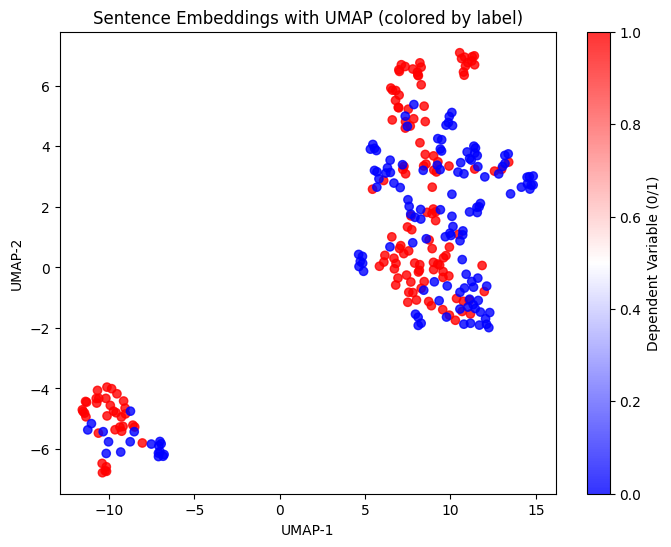

In [ ]:
# Some Overlap is expected
#High-dimensional separation may not be visible in 2d
#Can try diff embedding/tokenizer


# Scatterplot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=labels, cmap="bwr", alpha=0.8)
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title("Sentence Embeddings with UMAP (colored by label)")
plt.colorbar(scatter, label="Dependent Variable (0/1)")
plt.show()